In [1]:
#! pip install plot-metric
import pickle
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, roc_curve
import matplotlib.pyplot as plt
import torch
import joblib

path_csv = "../../../Thesis_data/processed_data/"
path_model = "../../../Thesis_data/Models/"

In [2]:
#https://mikulskibartosz.name/how-to-reduce-memory-usage-in-pandas

def rm(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [3]:
results = pd.DataFrame(columns=["Model", "AUROC", "Balanced Accuracy", "F1", "Recall", "Precision"])

def evaluation(y_test_input, y_pred_input, model_name, y_pred_proba_input):

    auroc = round(roc_auc_score(y_test_input, y_pred_proba_input),3)
    bal_acc = round(balanced_accuracy_score(y_test_input, y_pred_input),3)
    f1 = round(f1_score(y_test_input, y_pred_input),3)
    recall = round(recall_score(y_test_input, y_pred_input),3)
    precis = round(precision_score(y_test_input, y_pred_input),3)

    results.loc[len(results)+1] = [type(model_name).__name__, auroc, bal_acc, f1, recall, precis]

    print("AUROC Score: ", auroc)
    print("Balanced Accuracy Score: ", bal_acc)
    print("F1 Score: ", f1)
    print("Recall Score: ", recall)
    print("Precision Score: ", precis)
    cm = confusion_matrix(y_test_input, y_pred_input)

    fig, ax = plt.subplots(figsize=(4, 6))
    ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')
    
    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    plt.title('Confusion Matrix', fontsize=18)
    plt.show()

In [4]:
X_test = pd.read_csv(path_csv + "ontime_reporting_X_test.csv")
y_test = pd.read_csv(path_csv + "ontime_reporting_y_test.csv")

In [5]:
X_test = rm(X_test)
y_test = np.ravel(y_test)

Memory usage of dataframe is 314.23 MB
Memory usage after optimization is: 78.56 MB
Decreased by 75.0%


## Evaluate Logistic Regression tuned ROS+RUS model

In [6]:
logreg_tuned_rosrus = joblib.load(path_model + "logreg_tuned_ROSRUS.joblib")
y_pred_logreg_tuned_rosrus = logreg_tuned_rosrus.predict(X_test)
y_pred_prob_logreg_tuned_rosrus = logreg_tuned_rosrus.predict_proba(X_test)[:, 1]

C:\Users\Rvanl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:299: UserWarning: Trying to unpickle estimator LogisticRegression from version 1.2.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


AUROC Score:  0.74
Balanced Accuracy Score:  0.683
F1 Score:  0.481
Recall Score:  0.499
Precision Score:  0.465


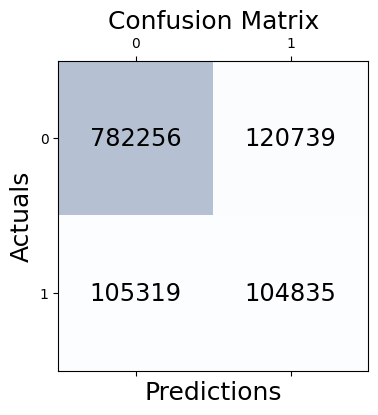

In [7]:
evaluation(y_test, y_pred_logreg_tuned_rosrus, logreg_tuned_rosrus, y_pred_prob_logreg_tuned_rosrus)

## Evaluate XGBoost tuned ROS+RUS model

In [ ]:
xgb_class_tuned_rosrus = joblib.load(path_model + "XGBoost_tuned_ROSRUS.joblib")
y_pred_xgb_tuned_rosrus = xgb_class_tuned_rosrus.predict(X_test)
y_pred_prob_xgb_tuned_rosrus = xgb_class_tuned_rosrus.predict_proba(X_test)[:, 1]

In [ ]:
evaluation(y_test, y_pred_xgb_tuned_rosrus, xgb_class_tuned_rosrus, y_pred_prob_xgb_tuned_rosrus)

## Evaluate TabNet tuned ROS+RUS model

In [ ]:
tabnet_tuned_rosrus = torch.load(path_model + "TabNet_tuned_ROSRUS.pt", map_location=torch.device('cpu'))
tabnet_tuned_rosrus.device = "cpu"
y_pred_tabnet_tuned_rosrus = tabnet_tuned_rosrus.predict(X_test.values)
y_pred_prob_tabnet_tuned_rosrus = tabnet_tuned_rosrus.predict_proba(X_test.values)[:, 1]

In [ ]:
evaluation(y_test, y_pred_tabnet_tuned_rosrus, tabnet_tuned_rosrus, y_pred_prob_tabnet_tuned_rosrus)

## Evaluate Random Forests tuned ROS+RUS model

In [8]:
rf_tuned_rosrus = joblib.load(path_model + "rf_tuned_ROSRUS.joblib")
y_pred_rf_tuned_rosrus = rf_tuned_rosrus.predict(X_test)
y_pred_prob_rf_tuned_rosrus = rf_tuned_rosrus.predict_proba(X_test)[:, 1]

C:\Users\Rvanl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:299: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Rvanl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:299: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
[Parallel(n_jobs=8)]: Using ba

AUROC Score:  0.798
Balanced Accuracy Score:  0.726
F1 Score:  0.543
Recall Score:  0.584
Precision Score:  0.506


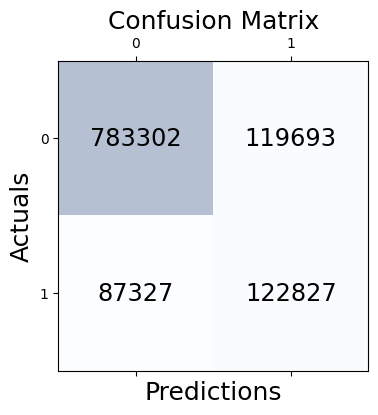

In [9]:
evaluation(y_test, y_pred_rf_tuned_rosrus, rf_tuned_rosrus, y_pred_prob_rf_tuned_rosrus)

In [10]:
results.sort_values(by=["AUROC"], ascending=False)

,Model,AUROC,Balanced Accuracy,F1,Recall,Precision
2,RandomForestClassifier,0.798,0.726,0.543,0.584,0.506
1,LogisticRegression,0.740,0.683,0.481,0.499,0.465


In [ ]:
#Plot AUROC for LogReg
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_logreg_tuned_rosrus)
auc = round(roc_auc_score(y_test, y_pred_prob_logreg_tuned_rosrus), 3)
plt.plot(fpr, tpr, linestyle='--', label="Logistic Regression, AUC="+str(auc))

#Plot AUROC for XGBoost
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_xgb_tuned_rosrus)
auc = round(roc_auc_score(y_test, y_pred_prob_xgb_tuned_rosrus), 3)
plt.plot(fpr, tpr, linestyle='--', label="Gradient Boosting, AUC="+str(auc))

#Plot AUROC for TabNet
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_tabnet_tuned_rosrus)
auc = round(roc_auc_score(y_test, y_pred_prob_tabnet_tuned_rosrus), 3)
plt.plot(fpr, tpr, linestyle='--', label="TabNet, AUC="+str(auc))

#Plot AUROC for Random Forests
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_rf_tuned_rosrus)
auc = round(roc_auc_score(y_test, y_pred_prob_rf_tuned_rosrus), 3)
plt.plot(fpr, tpr, linestyle='--', label="Random Forests, AUC="+str(auc))

#Add baseline of 0.5 random guesser
plt.plot([0, 1], [0, 1], color='gray')

#Add legend
plt.legend()

#Add labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')


plt.figure(figsize=(14, 12)) 
plt.show()